### Import Model Architectures
Custom Torch Models need to be instantiated for evaluation. The model_architectures.py file contains the model architectures so we can abstract it and focus only on the evaluations.

In [1]:
from model_architectures import *
import model_architectures
from attacks import * 
# Print available classes to verify our model architectures were imported
print(dir(model_architectures))

Using device: cuda
Using device: cuda
['BasicBlock', 'DataLoader', 'F', 'Load', 'ResNetCIFAR', 'ResNetMNIST', 'ResnetSVHN', 'TensorDataset', 'Tester', 'Visualizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cifar_directory', 'conv3x3', 'current_directory', 'device', 'mnist_directory', 'nn', 'np', 'os', 'pd', 'pickle', 'plt', 'scipy', 'svhn_directory', 'torch']


### Loading the Model Weights
Using our model artifacts we load the weights back into the model so we have our pre-trained models to test our perturbations against.

In [2]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

#add map_location=torch.device('cpu') if running locally and ur not sai lol
device = 'cuda'
# mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth", map_location=torch.device(device)))
# cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth", map_location=torch.device(device)))
# svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth",map_location=torch.device(device)))
mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth"))
cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth"))
svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth"))

<All keys matched successfully>

In [3]:
# Set models to evaluation mode
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [4]:
# Loading Data
loader = Load()
mnist_test_images, mnist_test_labels = loader.load_mnist_test_images()
cifar10_test_images, cifar10_test_labels = loader.load_cifar10_test_images()
svhn_test_images, svhn_test_labels = loader.load_svhn_test_images()

In [5]:
test_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_test_images[:256], mnist_test_labels[:256])
test_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_test_images[:256], cifar10_test_labels[:256])
test_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_test_images[:256], svhn_test_labels[:256])
tester = Tester()

### Fast Gradient Sign Method
The ``fgsm_attack`` function takes three
inputs, *image* is the original clean image ($x$), *epsilon* is
the pixel-wise perturbation amount ($\epsilon$), and *data_grad*
is gradient of the loss w.r.t the input image
($\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$). The function
then creates perturbed image as

\begin{align}
\text{perturbed\_image} &= \text{image} + \epsilon \cdot \text{sign}(\text{data\_grad}) \\
&x = x + \epsilon \cdot \text{sign}(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))
\end{align}

Fast Gradient Sign Method uses $L^∞$ Norm Perturbations

In [6]:
def test_fgsm(model, test_loader, epsilon):
    correct = 0
    total = 0

    adv_examples = []
    batch = 0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        batch += 1
        print(f"Batch: {batch}, Epsilon: {epsilon}, Correct: {correct}")
        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)
            image.requires_grad = True
            output, _ = model(image)

            # print(outputs)

            _, init_pred = torch.max(output.data, 1)

            if not torch.equal(init_pred, label):
                total +=1 
                continue
            
            loss = F.nll_loss(output, label)
            model.zero_grad()
            loss.backward()
            data_grad = image.grad.data
            perturbed_data = fgsm_attack(image, epsilon, data_grad)

            output_final, _ = model(perturbed_data)
            _, final_pred = torch.max(output_final.data, 1)
            if torch.equal(final_pred, label):
                correct += 1
                if epsilon == 0 and len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            total +=1 

    accuracy = correct / total
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {total} = {accuracy}")
    return accuracy, adv_examples

Batch: 1, Epsilon: 0, Correct: 0
Epsilon: 0	Test Accuracy = 255 / 256 = 0.99609375
Batch: 1, Epsilon: 0.05, Correct: 0
Epsilon: 0.05	Test Accuracy = 233 / 256 = 0.91015625
Batch: 1, Epsilon: 0.1, Correct: 0
Epsilon: 0.1	Test Accuracy = 109 / 256 = 0.42578125
Batch: 1, Epsilon: 0.15, Correct: 0
Epsilon: 0.15	Test Accuracy = 18 / 256 = 0.0703125
Batch: 1, Epsilon: 0.2, Correct: 0
Epsilon: 0.2	Test Accuracy = 1 / 256 = 0.00390625
Batch: 1, Epsilon: 0.25, Correct: 0
Epsilon: 0.25	Test Accuracy = 0 / 256 = 0.0
Batch: 1, Epsilon: 0.5, Correct: 0
Epsilon: 0.5	Test Accuracy = 0 / 256 = 0.0
[0.99609375, 0.91015625, 0.42578125, 0.0703125, 0.00390625, 0.0, 0.0]


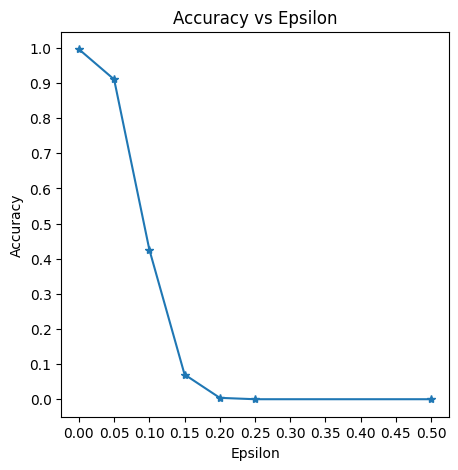

In [7]:
# MNIST

epsilons = [0, .05, .1, .15, .2, .25, .5]
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_fgsm(mnist_resnet_model, test_loader_mnist, eps)
    accuracies.append(acc)
    examples.append(ex)

print(accuracies)

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .55, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

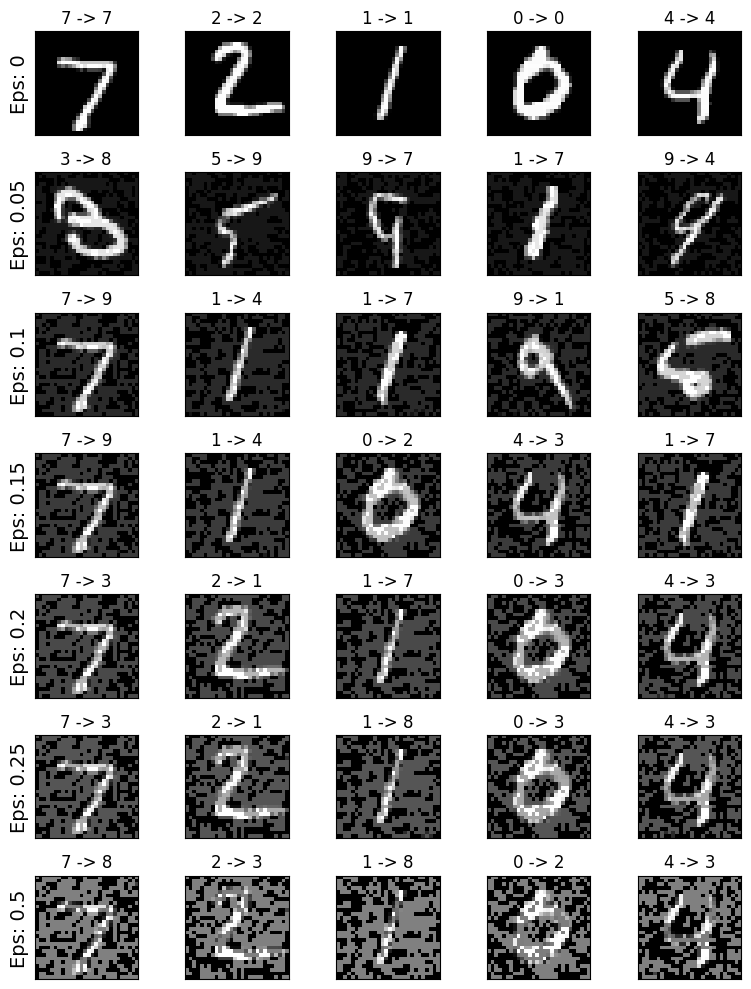

In [8]:
# MNIST Viewer
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

Batch: 1, Epsilon: 0, Correct: 0
Epsilon: 0	Test Accuracy = 190 / 256 = 0.7421875
Batch: 1, Epsilon: 0.05, Correct: 0
Epsilon: 0.05	Test Accuracy = 0 / 256 = 0.0
Batch: 1, Epsilon: 0.1, Correct: 0
Epsilon: 0.1	Test Accuracy = 0 / 256 = 0.0
Batch: 1, Epsilon: 0.15, Correct: 0
Epsilon: 0.15	Test Accuracy = 1 / 256 = 0.00390625
Batch: 1, Epsilon: 0.2, Correct: 0
Epsilon: 0.2	Test Accuracy = 1 / 256 = 0.00390625
Batch: 1, Epsilon: 0.25, Correct: 0
Epsilon: 0.25	Test Accuracy = 3 / 256 = 0.01171875
Batch: 1, Epsilon: 0.5, Correct: 0
Epsilon: 0.5	Test Accuracy = 3 / 256 = 0.01171875
[0.7421875, 0.0, 0.0, 0.00390625, 0.00390625, 0.01171875, 0.01171875]


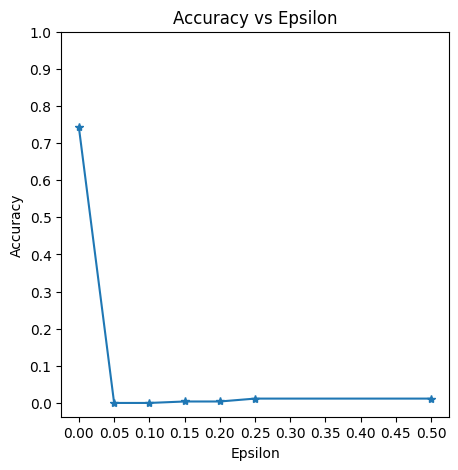

In [18]:
# CIFAR10

epsilons = [0, .05, .1, .15, .2, .25, .5]
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_fgsm(cifar_resnet_model, test_loader_cifar10, eps)
    accuracies.append(acc)
    examples.append(ex)

print(accuracies)

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .55, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

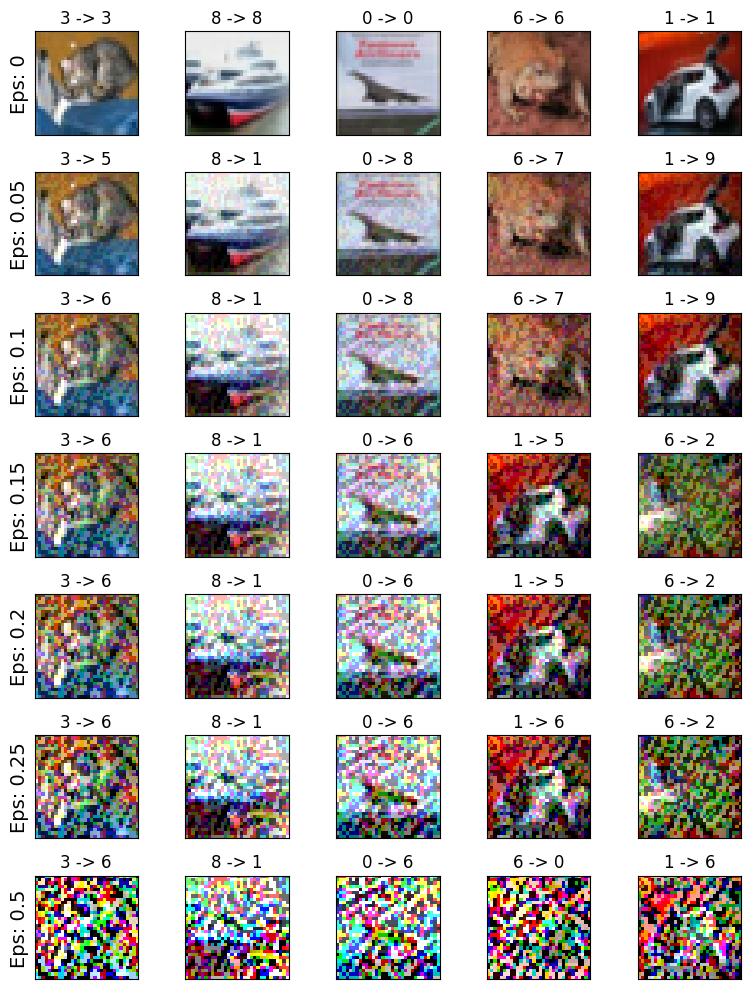

In [19]:
# CIFAR10/SVHN Viewer
num_cols = len(examples[0])
plt.figure(figsize=(8, 10))
for i in range(len(epsilons)):
    for j in range(num_cols):
        plt.subplot(len(epsilons), num_cols, i * num_cols + j + 1)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        if j < len(examples[i]):
            orig, adv, ex = examples[i][j]
            # Assuming ex is of shape (3, 32, 32)
            ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
            # ex = ex / 255 # Normalizing pixel values
            plt.title(f"{orig} -> {adv}")
            plt.imshow(ex)
        else:
            plt.axis('off')  # Turn off empty subplots
plt.tight_layout()
plt.show()

Batch: 1, Epsilon: 0, Correct: 0
Epsilon: 0	Test Accuracy = 237 / 256 = 0.92578125
Batch: 1, Epsilon: 0.05, Correct: 0
Epsilon: 0.05	Test Accuracy = 23 / 256 = 0.08984375
Batch: 1, Epsilon: 0.1, Correct: 0
Epsilon: 0.1	Test Accuracy = 16 / 256 = 0.0625
Batch: 1, Epsilon: 0.15, Correct: 0
Epsilon: 0.15	Test Accuracy = 13 / 256 = 0.05078125
Batch: 1, Epsilon: 0.2, Correct: 0
Epsilon: 0.2	Test Accuracy = 11 / 256 = 0.04296875
Batch: 1, Epsilon: 0.25, Correct: 0
Epsilon: 0.25	Test Accuracy = 14 / 256 = 0.0546875
Batch: 1, Epsilon: 0.5, Correct: 0
Epsilon: 0.5	Test Accuracy = 15 / 256 = 0.05859375
[0.92578125, 0.08984375, 0.0625, 0.05078125, 0.04296875, 0.0546875, 0.05859375]


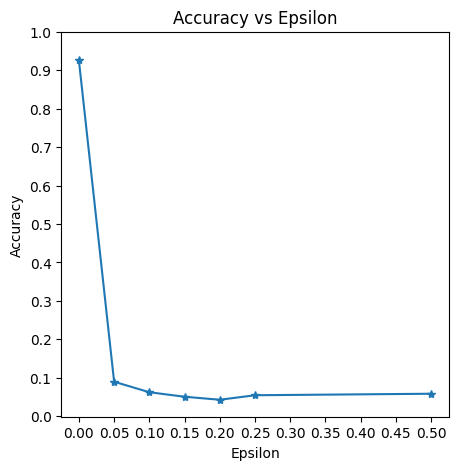

In [11]:
# SVHN

epsilons = [0, .05, .1, .15, .2, .25, .5]
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_fgsm(svhn_resnet_model, test_loader_svhn, eps)
    accuracies.append(acc)
    examples.append(ex)

print(accuracies)

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .55, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

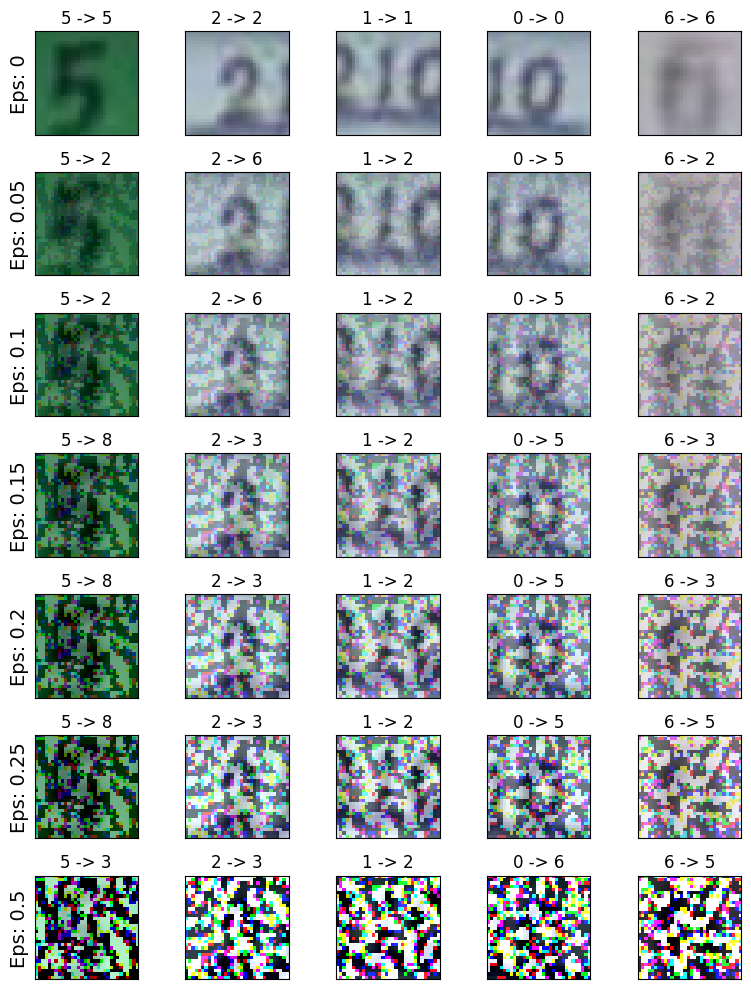

In [17]:
# CIFAR10/SVHN Viewer
num_cols = len(examples[0])
plt.figure(figsize=(8, 10))
for i in range(len(epsilons)):
    for j in range(num_cols):
        plt.subplot(len(epsilons), num_cols, i * num_cols + j + 1)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        if j < len(examples[i]):
            orig, adv, ex = examples[i][j]
            # Assuming ex is of shape (3, 32, 32)
            ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
            # ex = ex / 255  # Normalizing pixel values
            plt.title(f"{orig} -> {adv}")
            plt.imshow(ex)
        else:
            plt.axis('off')  # Turn off empty subplots
plt.tight_layout()
plt.show()